In [163]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [164]:
words = open('../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(f'vocab_size: {vocab_size}')

vocab_size: 27


In [165]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # split up dataset
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*X.shape[0])
    n2 = int(0.9*X.shape[0])
    Xtr, Xdev, Xte = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yte = Y.tensor_split((n1, n2), dim=0)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte 

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words, block_size)
print(f'context length: {block_size}')
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

context length: 3


(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

In [166]:
'''
    Linear layer module
'''
class Linear:
    def __init__(
        self, 
        fan_in, # number of inputs coming into the linear layer (spread like a fan)
        fan_out, # number of outputs coming out of the linear layer (spread out like a fan)
        g=torch.Generator().manual_seed(2147483647), # generator for weights for Andrej reproducibility
        bias=True # bias constants are defaulted to be true         
    ) -> None:
        '''
        initialize the linear layer
        '''
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    
    def __call__(self, x):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [167]:
'''
    BatchNorm module
'''
class BatchNorm1D:
    def __init__(
        self,
        dim, # number of features that the batchnorm layer will have
        eps=1e-5,  # epsilon--keeps std well-behaved when its value hovers around 0
        momentum=0.1 # increment used for updating the running mean and std
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True # boolean for whether we are training or testing the model
        # parameters trained through back propogation, in PyTorch notation
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # ---------------------------
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # biases
        # ---------------------------
        # "buffers" which are trained through a running 'momentum-based update'
        # ---------------------------
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # ---------------------------

        
    def __call__(self, x):
        '''
        calculate the Forward pass for the input x
        '''
        if self.training: # if we're training the model, calculate mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: # if we're validating or testing our model, use running quantities
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize input to unit variance
        self.out = self.gamma * xhat + self.beta # normally not in pytorch, but we want statistics
        
        # update the buffers while we're training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar
        return self.out 

    def parameters(self):
        return [self.gamma, self.beta]

In [168]:
'''
    tanh module 
'''
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

### Network initialization

In [17]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding tensor
layers = [ # one linear layer, then four hidden layers, then one output layer = 6 layer MLP
    Linear(n_embd*block_size, n_hidden),  BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size), BatchNorm1D(vocab_size),
]

''' # NO BATCHNORM LAYERS -- ONLY LINEAR
layers = [ # one linear layer, then four hidden layers, then one output layer = 6 layer MLP
    Linear(n_embd*block_size, n_hidden),  Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size),
]
'''

with torch.no_grad():
    #layers[-1].weight += 0.1 # make the last layer less confident
    layers[-1].gamma += 0.1 # need to adjust gamma now since the last layer is batchnorm
    for layer in layers[:-1]: # apply gain to all other layers
        if isinstance(layer, Linear): # check whether, as we're iterating, we're looking at a layer
            layer.weight *= 5/3 # apply the gain factor according to tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 47551


### Training the neural network

In [18]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # this is our update / data ratio list which will keep track of ratios between update and data

for i in range(max_steps):
    ### construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    ### forward pass
    emb = C[Xb] # embed all characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ### backward pass
    for layer in layers:
        layer.out.retain_grad() # tells pytorch to keep gradient, useful for debugging
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ### update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track where we are in the training
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
print('----------')        
print(f'final loss: {10**lossi[-1]}')

loss at step 0 of 200000: 3.9328
----------
final loss: 2.094924007266694


### Plotting tools for understanding how neural network is changing during training

In [90]:
def plot_histogram_data(option):
    plt.figure(figsize=(20,4)) # width and height of the plot
    legends = []
    
    if option == 'activations':
        ### plot the activation distributions
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, Linear):
                t = layer.out
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('activation distribution');
        
    elif option == 'gradients':
        ### plot gradient distributions within layers
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, Tanh):
                t = layer.out.grad
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('gradient distribution');
        
    elif option == 'weights':
        ### plot weights distribution in network
        for i, p in enumerate(parameters):
            t = p.grad
            if p.ndim == 2: # this is only true for anything that has two dimensions, i.e. the weights
                print(f'weight {tuple(p.shape)} mean {t.mean():.3f}, std {t.std():.3f}, grad/data ratio: {(t.std()/p.std()):.2f}')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'{i} ({tuple(p.shape)})')

        plt.legend(legends);
        plt.title('weight distribution');
    
    elif option == 'udratio':
        ### plot ratio of update step (lr * self.grad) to value of data
        for i, p in enumerate(parameters):
            if p.ndim == 2:
                plt.plot([ud[j][i] for j in range(len(ud))])
                legends.append(f'param {i}')
        plt.plot([0, len(ud)], [-3, -3], 'k') # we're expecting the ratios to be ~1e-3
        plt.legend(legends);

weight (27, 10) mean 0.000, std 0.000, grad/data ratio: 0.00
weight (30, 100) mean 0.000, std 0.000, grad/data ratio: nan
weight (100, 100) mean 0.000, std 0.000, grad/data ratio: nan
weight (100, 100) mean 0.000, std 0.000, grad/data ratio: nan
weight (100, 100) mean 0.000, std 0.000, grad/data ratio: nan
weight (100, 100) mean 0.000, std 0.000, grad/data ratio: nan
weight (100, 27) mean 0.000, std 0.000, grad/data ratio: nan


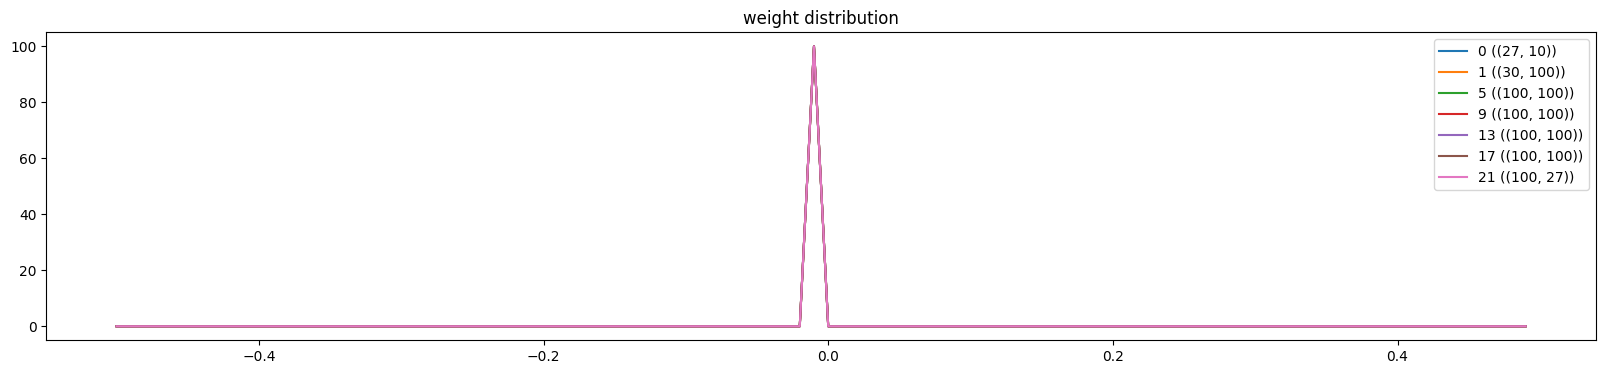

In [91]:
'''  Options for plotting neural network parameter changes 
-----
activations: plot what the activation distributions are doing -- check squashing effects
gradients: what the gradients are doing -- check even-ness of gradient changes during training (forces are equal)
weights: what the weights are doing --  check how large grads are to data, to see how much they're changing
udratio: plot the ratio between the update step and the data, in terms of std (the spread of values)
-----
'''
plot_histogram_data('weights');

### Below are extra plotting tools by Andrej to further visualize behavior (?)

In [45]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5 # random tensor of dim (5,)
    print(f'original x: {x}')
    
    x[0] = x0 # override the 0th example with the slider
    print(f'x modified: {x}')

    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig # BatchNorm with no bias or gain

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
        # plot the input and output values
        plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100) # where our values originally were
        plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100) # post-BatchNorm on the y=0 axis
        plt.xlim(-6, 6)
        # title
        plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

### This really visualizes how BatchNorm transforms input vectors into a unit Gaussian distribution through the connections from the blue inputs to the red outputs!

In [46]:
# Linear: activation statistics of forward and backward pass
g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [47]:
# Linear + BatchNorm: activation statistics of forward and backward pass
g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


### BatchNorm does a great job of normalizing everything!

## Now onto E01:

We see that the deepest layers in the network are training---this means the network is being partially trained, but as we can see by looking at the udratio, it's being trained very poorly. We can increase the number of steps to see how good it could get, but the fact of the matter is that when initializing all weights, biases and gains to zero, this causes many problems, and it's much better randomly initialize these parameters so that the network will be more responsive during training

In [132]:
class Linear:
    def __init__(
        self, 
        fan_in, # number of inputs coming into the linear layer (spread like a fan)
        fan_out, # number of outputs coming out of the linear layer (spread out like a fan)
        g=torch.Generator().manual_seed(2147483647), # generator for weights for Andrej reproducibility
        bias=True # bias constants are defaulted to be true         
    ) -> None:
        '''
        initialize the linear layer
        '''
        #self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.weight = torch.zeros((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None # this is already zero'd out
        
    
    def __call__(self, x):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [141]:
class BatchNorm1D:
    def __init__(
        self,
        dim, # number of features that the batchnorm layer will have
        eps=1e-5,  # epsilon--keeps std well-behaved when its value hovers around 0
        momentum=0.1 # increment used for updating the running mean and std
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True # boolean for whether we are training or testing the model
        # parameters trained through back propogation, in PyTorch notation
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # ---------------------------
        #self.gamma = torch.ones(dim) # gain -- not zero'ing this out yet
        self.gamma = torch.zeros(dim) # gain -- not zero'ing this out yet
        self.beta = torch.zeros(dim) # biases
        # ---------------------------
        # "buffers" which are trained through a running 'momentum-based update'
        # ---------------------------
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # ---------------------------

        
    def __call__(self, x):
        '''
        calculate the Forward pass for the input x
        '''
        if self.training: # if we're training the model, calculate mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: # if we're validating or testing our model, use running quantities
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize input to unit variance
        self.out = self.gamma * xhat + self.beta # normally not in pytorch, but we want statistics
        
        # update the buffers while we're training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar
        return self.out 

    def parameters(self):
        return [self.gamma, self.beta]

In [142]:
# let's just see what's going on with the linear layers
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding tensor
layers = [ # one linear layer, then four hidden layers, then one output layer = 6 layer MLP
    Linear(n_embd*block_size,  n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    #layers[-1].weight += 0.1 # make the last layer less confident
    layers[-1].gamma += 0.1 # need to adjust gamma now since the last layer is batchnorm
    for layer in layers[:-1]: # apply gain to all other layers
        if isinstance(layer, Linear): # check whether, as we're iterating, we're looking at a layer
            layer.weight *= 5/3 # apply the gain factor according to tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [159]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # this is our update / data ratio list which will keep track of ratios between update and data

for i in range(max_steps):
    ### construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    ### forward pass
    emb = C[Xb] # embed all characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ### backward pass
    for layer in layers:
        layer.out.retain_grad() # tells pytorch to keep gradient, useful for debugging
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ### update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track where we are in the training
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 10_000:
        break
print('----------')        
print(f'final loss: {10**lossi[-1]}')

loss at step 0 of 200000: 2.7250
loss at step 10000 of 200000: 3.3781
----------
final loss: 3.3781200506904745


In [184]:
def plot_histogram_data(option):
    plt.figure(figsize=(20,4)) # width and height of the plot
    legends = []
    
    if option == 'activations':
        ### plot the activation distributions
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, Linear):
                t = layer.out
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('activation distribution');
        
    if option == 'batch output':
        ### plot the activation distributions
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, BatchNorm1D):
                t = layer.out
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('BatchNorm distribution');
        
    elif option == 'tanh gradients':
        ### plot gradient distributions within layers
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, Tanh):
                t = layer.out.grad
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('gradient distribution');
        
    elif option == 'batch gradients':
        ### plot gradient distributions within layers
        for i, layer in enumerate(layers[:-1]): # iterating through all layers except output layer
            if isinstance(layer, BatchNorm1D):
                t = layer.out.grad
                print(f'layer {i} layer {layer.__class__.__name__}: mean {t.mean():.3f}, std {t.std():.3f}, saturated {(t.abs() > 0.97).float().mean()*100:.2f}%')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'layer {i} ({layer.__class__.__name__})')

        plt.legend(legends);
        plt.title('batch gradient distribution');
        
    elif option == 'weights':
        ### plot weights distribution in network
        for i, p in enumerate(parameters):
            t = p.grad
            if p.ndim == 2: # this is only true for anything that has two dimensions, i.e. the weights
                print(f'weight {tuple(p.shape)} mean {t.mean():.3f}, std {t.std():.3f}, grad/data ratio: {(t.std()/p.std()):.2f}')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach()) # detach is useful for visualization w/o interrupting training
                legends.append(f'{i} ({tuple(p.shape)})')

        plt.legend(legends);
        plt.title('weight distribution');
    
    elif option == 'udratio':
        ### plot ratio of update step (lr * self.grad) to value of data
        for i, p in enumerate(parameters):
            if p.ndim == 2:
                plt.plot([ud[j][i] for j in range(len(ud))])
                legends.append(f'param {i}')
        plt.plot([0, len(ud)], [-3, -3], 'k') # we're expecting the ratios to be ~1e-3
        plt.legend(legends);

layer 2 layer Tanh: mean 0.000, std 0.000, saturated 0.00%
layer 5 layer Tanh: mean 0.000, std 0.000, saturated 0.00%
layer 8 layer Tanh: mean 0.000, std 0.000, saturated 0.00%
layer 11 layer Tanh: mean 0.000, std 0.000, saturated 0.00%
layer 14 layer Tanh: mean 0.000, std 0.158, saturated 0.00%


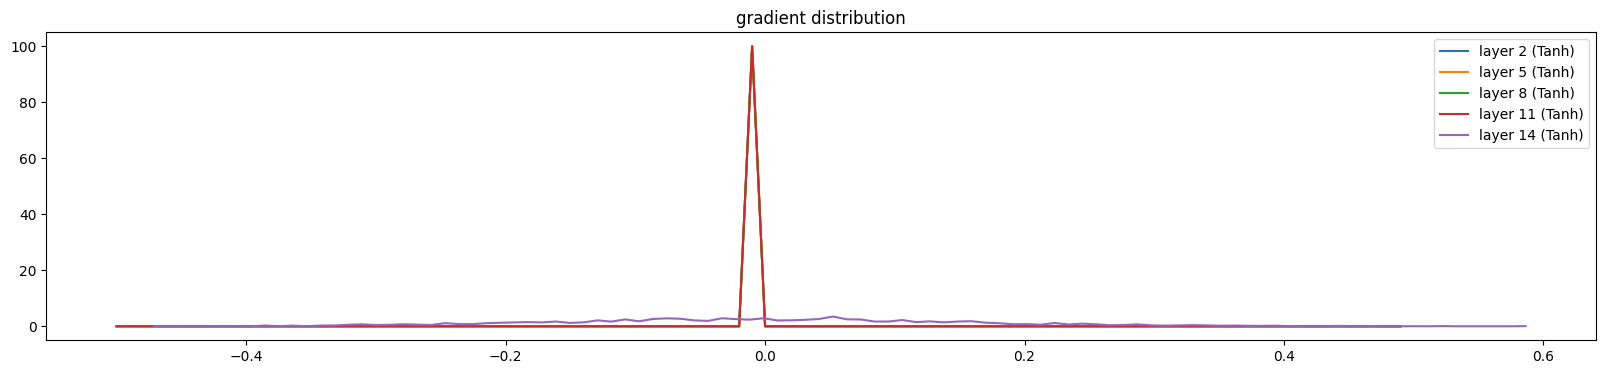

In [162]:
plot_histogram_data('tanh gradients');

### EO2: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [194]:
'''
    Linear layer module
'''
class Linear:
    def __init__(
        self, 
        fan_in, # number of inputs coming into the linear layer (spread like a fan)
        fan_out, # number of outputs coming out of the linear layer (spread out like a fan)
        g=torch.Generator().manual_seed(2147483647), # generator for weights for Andrej reproducibility
        bias=True # bias constants are defaulted to be true         
    ) -> None:
        '''
        initialize the linear layer
        '''
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    
    def __call__(self, x):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        ''' 
        __call__ allows you to call the class like a function to do something
        in this case, when providing an input, __call__ will provide an output of the linear layer 
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [195]:
'''
    BatchNorm module
'''
class BatchNorm1D:
    def __init__(
        self,
        dim, # number of features that the batchnorm layer will have
        eps=1e-5,  # epsilon--keeps std well-behaved when its value hovers around 0
        momentum=0.1 # increment used for updating the running mean and std
    ) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True # boolean for whether we are training or testing the model
        # parameters trained through back propogation, in PyTorch notation
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # ---------------------------
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # biases
        # ---------------------------
        # "buffers" which are trained through a running 'momentum-based update'
        # ---------------------------
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # ---------------------------

        
    def __call__(self, x):
        '''
        calculate the Forward pass for the input x
        '''
        if self.training: # if we're training the model, calculate mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: # if we're validating or testing our model, use running quantities
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize input to unit variance
        self.out = self.gamma * xhat + self.beta # normally not in pytorch, but we want statistics
        
        # update the buffers while we're training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * xvar
        return self.out 

    def parameters(self):
        return [self.gamma, self.beta]

In [196]:
'''
    tanh module 
'''
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [197]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g) # embedding tensor
layers = [ # 3 layer MLP = input layer + hidden layer + output layer
    Linear(n_embd*block_size, n_hidden),  BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,           vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    #layers[-1].weight += 0.1 # make the last layer less confident
    layers[-1].gamma += 0.1 # need to adjust gamma now since the last layer is batchnorm
    for layer in layers[:-1]: # apply gain to all other layers
        if isinstance(layer, Linear): # check whether, as we're iterating, we're looking at a layer
            layer.weight *= 5/3 # apply the gain factor according to tanh
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 16651


Now we train the 3 layer MLP

In [198]:
max_steps = 10_000
batch_size = 32
lossi = []
ud = [] # this is our update / data ratio list which will keep track of ratios between update and data

for i in range(max_steps):
    ### construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    ### forward pass
    emb = C[Xb] # embed all characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ### backward pass
    for layer in layers:
        layer.out.retain_grad() # tells pytorch to keep gradient, useful for debugging
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ### update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track where we are in the training
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
print('----------')        
print(f'final loss: {10**lossi[-1]}')

loss at step 0 of 10000: 3.9654
----------
final loss: 2.1146581232115524


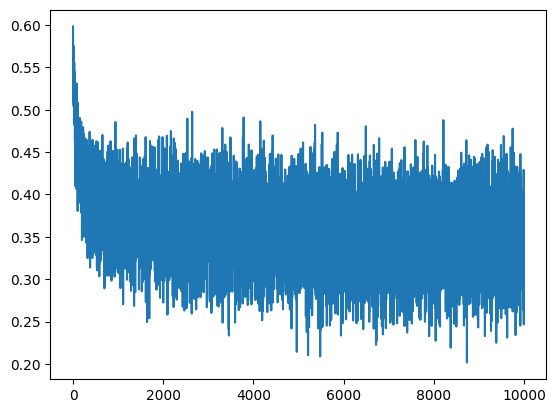

In [199]:
plt.plot(lossi);

layer 2 layer Tanh: mean 0.000, std 0.005, saturated 0.00%
layer 5 layer Tanh: mean -0.000, std 0.004, saturated 0.00%


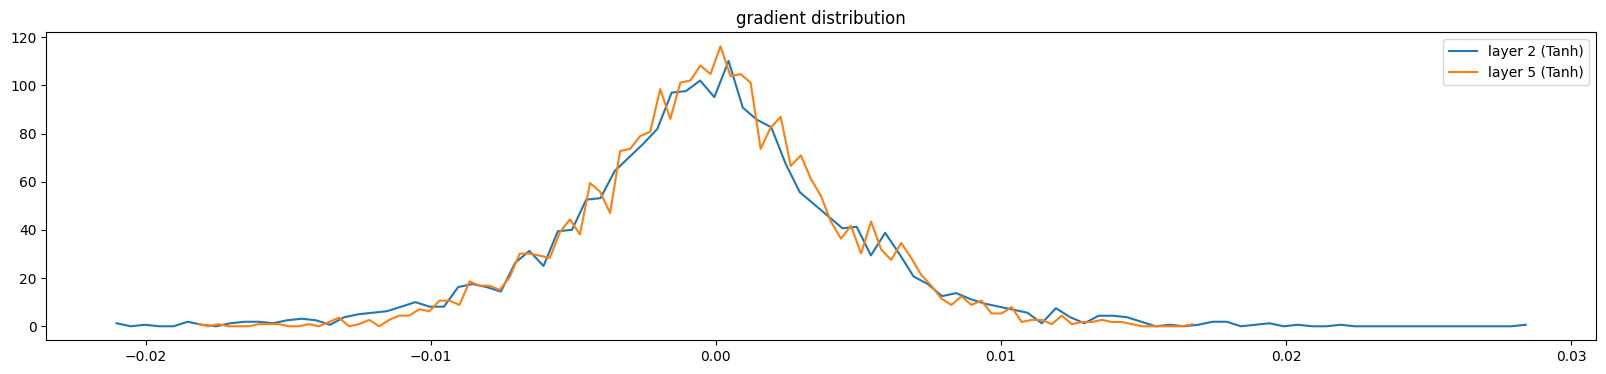

In [203]:
plot_histogram_data('tanh gradients')

### Now we need to 'fold' the BatchNorm into the linear layers which will undo the BatchNorm

currently getting errors since I don't know exactly how I should define my x so that we'll be able to get the multiplication down

In [230]:
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        #print(f'layer {i} weight: {layer.weight}, bias: {layer.bias}')
        # create an x like it's a BatchNorm and use that to fold it back into the weights and bias?
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
        print(ix.shape)
        emb = C[Xb] # embed all characters into vectors
        print(emb.shape)
        x = emb.view(emb.shape[0], -1) # concatenate all vectors
        xmean = x.mean(dim=0, keepdim=True)
        xvar = x.var(dim=0, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + 1e-5) # normalize input to unit variance
        
        # now let's fold this back into our layer
        layer.parameters = xhat @ layer.weight + layer.bias

torch.Size([32])
torch.Size([32, 3, 10])
torch.Size([32])
torch.Size([32, 3, 10])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x30 and 100x100)